# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [6]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))
example_files = np.array(glob("example_dataset/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
print('There are %d total example images.' % len(example_files))

There are 13233 total human images.
There are 8351 total dog images.
There are 15 total example images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [7]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Number of faces detected: 1


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# display faces detected, placing rectangle around each human face within the image
def display_faces_with_rectangle_around_face_cv(full_img, faces_in_images, rect_color=(0,255,0)):  
    '''
    Displays a rectangle around the detected faces
    
    Args:
        img: an image
        faces_in_images: list of face locations within the given 
                         image with the following tuple (x, y, width, and height) 
                         of each face 
        rect_color: color of rectangle in rgb tuple 
                    Defaults to (0, 255, 0) Green
    Returns:
        None
    '''
    
    for (x,y,w,h) in faces_in_images:
        
        # add bounding box to color image
        cv2.rectangle(full_img, (x,y), (x+w,y+h), rect_color, 2) # takes in  
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
    
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

    
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path, display=False):
    '''
    Detects a human face
    Args:
        img_path: a path to an image
        display: display image with rectangles around detected faces if True (bool)
        
    Returns:
        if there is a human face in the image (bool)
    '''
    # Reads in image
    img = cv2.imread(img_path)
    # converts image to Gray Scale from OpenCV's Default BGR image object
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # detects human faces
    faces = face_cascade.detectMultiScale(gray)

    # display faces 
    if display:
        display_faces_with_rectangle_around_face_cv(img, faces)
    return len(faces) > 0

In [16]:
example_count = 10

print("Image Display Test:")
results = face_detector(example_files[0], display=True)
print(results)
print()
print("Example Dataset:")
for example_img_path in example_files:
    results = face_detector(example_img_path)
    print(results)

print()
print("Human Dataset:")
for human_img_path in human_files[:example_count]:
    results = face_detector(human_img_path)
    print(results)

print()
print("Dog Dataset:")
for dog_img_path in dog_files[:example_count]:
    results = face_detector(dog_img_path)
    if results:
        print("{}\tUse the commented function 'display_faces_with_rectangle_around_face' to further understand results.\n\tFound in 'face_detection declaration.'".format(results))
    else:
        print(results)

Image Display Test:


True

Example Dataset:
True
False
True
False
False
False
True
True
False
False
True
True
False
False
False

Human Dataset:
True
True
True
True
True
True
True
True
True
True

Dog Dataset:
False
False
True	Use the commented function 'display_faces_with_rectangle_around_face' to further understand results.
	Found in 'face_detection declaration.'
False
False
False
False
False
False
False


### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)
```python
100%|██████████| 100/100 [00:01<00:00, 59.84it/s]
Percent of faces detected in a sample of the Human Dataset:	99.0% - time: 0:00:01.651157
100%|██████████| 100/100 [00:07<00:00, 13.18it/s]
Percent of faces detected in a sample of the Dog Dataset:	18.0% - time: 0:00:07.588281
```

In [17]:
from tqdm import tqdm
from datetime import datetime

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
human_faces_detected_in_human_files = 0
human_faces_detected_in_dog_files = 0

startTime = datetime.now()
for image_path in tqdm(human_files_short):
    if face_detector(image_path):
        human_faces_detected_in_human_files += 1
percent_of_human_faces_detected_in_human_files = human_faces_detected_in_human_files/len(human_files_short)*100
print("Percent of faces detected in a sample of the Human Dataset:\t{}% - time: {}".format(percent_of_human_faces_detected_in_human_files, datetime.now() - startTime))

startTime = datetime.now()
for image_path in tqdm(dog_files_short):
    if face_detector(image_path):
        human_faces_detected_in_dog_files += 1
percent_of_human_faces_detected_in_dog_files = human_faces_detected_in_dog_files/len(dog_files_short)*100
print("Percent of faces detected in a sample of the Dog Dataset:\t{}% - time: {}".format(percent_of_human_faces_detected_in_dog_files, datetime.now() - startTime))

  2%|▏         | 2/100 [00:00<00:07, 13.99it/s]

Percent of faces detected in a sample of the Human Dataset:	99.0% - time: 0:00:01.592262


100%|██████████| 100/100 [00:07<00:00, 12.74it/s]

Percent of faces detected in a sample of the Dog Dataset:	18.0% - time: 0:00:07.849297


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.
import face_recognition
def display_faces_with_rectangle_around_face_fr(img, faces_in_images, rect_color=(0,255,0)):  
    '''
    Displays a rectangle around the detected faces
    
    Args:
        img: an image
        faces_in_images: list of face locations within the given 
                         image with the following tuple (x, y, width, and height) 
                         of each face 
        rect_color: color of rectangle in rgb tuple 
                    Defaults to (0, 255, 0) Green
    Returns:
        None
    '''
    for (x,y,w,h) in faces_in_images:
        # add bounding box to color image
        cv2.rectangle(img, (y, x), (h, w), rect_color, 2)
  
    # display the image, along with bounding box
    plt.imshow(img)
    plt.show()
    
    
# returns "True" if face is detected in image stored at img_path
def face_detector_fr(img_path, display=False):        
    '''
    Detects a human face
    Args:
        img_path: a path to an image
        display: display image with rectangles around detected faces if True (bool)

    Returns:
        if there is a human face in the image (bool)
    '''
    # Reads in image
    img = face_recognition.load_image_file(img_path)

    # detects human faces
    faces = face_recognition.face_locations(img)

    # display faces
    if display:
        display_faces_with_rectangle_around_face_fr(img, faces)
    return len(faces) > 0

Image Display Test:


True

Example Dataset:
True
False
True
False
False
False
False
True
False
False
True
True
False
False
False

Human Dataset:
True
True
True
True
True
True
True
True
True
True

Dog Dataset:
False
False
True	Use the commented function 'display_faces_with_rectangle_around_face' to further understand results.
	Found in 'face_detection declaration.'
False
False
False
False
False
False
False


Image Display Test:


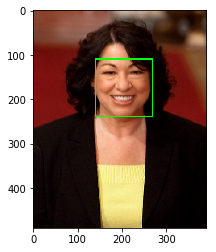

True

Example Dataset:
True
False
True
False
False
False
False
True
False
False
True
True
False
False
False

Human Dataset:
True
True
True
True
True
True
True
True
True
True

Dog Dataset:
False
False
True	Use the commented function 'display_faces_with_rectangle_around_face' to further understand results.
	Found in 'face_detection declaration.'
False
False
False
False
False
False
False


In [18]:
example_count = 10

print("Image Display Test:")
results = face_detector_fr(example_files[0], display=True)
print(results)
print()
print("Example Dataset:")
for human_img_path in example_files:
    results = face_detector_fr(human_img_path)
    print(results)

print()
print("Human Dataset:")
for human_img_path in human_files[:example_count]:
    results = face_detector_fr(human_img_path)
    print(results)

print()
print("Dog Dataset:")
for dog_img_path in dog_files[:example_count]:
    results = face_detector_fr(dog_img_path)
    if results:
        print("{}\tUse the commented function 'display_faces_with_rectangle_around_face' to further understand results.\n\tFound in 'face_detection declaration.'".format(results))
    else:
        print(results)

In [19]:
human_faces_detected_in_human_files = 0
human_faces_detected_in_dog_files = 0

startTime = datetime.now()
for image_path in tqdm(human_files_short):
    if face_detector_fr(image_path):
        human_faces_detected_in_human_files += 1
percent_of_human_faces_detected_in_human_files = human_faces_detected_in_human_files/len(human_files_short)*100
print("Percent of faces detected in a sample of the Human Dataset:\t{}% - time: {}".format(percent_of_human_faces_detected_in_human_files, datetime.now() - startTime))

startTime = datetime.now()
for image_path in tqdm(dog_files_short):
    if face_detector_fr(image_path):
        human_faces_detected_in_dog_files += 1

percent_of_human_faces_detected_in_dog_files = human_faces_detected_in_dog_files/len(dog_files_short)*100
print("Percent of faces detected in a sample of the Dog Dataset:\t{}%% - time: {}".format(percent_of_human_faces_detected_in_dog_files, datetime.now() - startTime))

  1%|          | 1/100 [00:00<00:15,  6.25it/s]

Percent of faces detected in a sample of the Human Dataset:	99.0% - time: 0:00:03.495616


100%|██████████| 100/100 [00:19<00:00,  1.10it/s]

Percent of faces detected in a sample of the Dog Dataset:	10.0%% - time: 0:00:19.458379


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [20]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [35]:
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torchvision.transforms as transforms

# Load and pre-process an image from the given img_path
def img_path_to_tensor(img_path):
    '''
    Opens an image file from its path and transforms with 
    resize and to tensor
    
    Args:
        img_path: path to an image
        
    Returns:
        A transformed image tensor
    '''
    # open image
    img = Image.open(img_path)
    
    # transform and convert to tensor
    img_transformer = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    return img_transformer(img)


# Return the *index* of the predicted class for that image
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''    
    # Sets the model in evaluation mode.
    VGG16.eval()
    
    # loads image, transforms, and converts to tensor
    img_tensor = img_path_to_tensor(img_path)
    
    # returns a new tensor with a dimension of size one.
    img_ready = img_tensor.unsqueeze(0)
    
    # no gradient calculated
    with torch.no_grad():
        # returns VGG16 models evaluation of image 
        results = VGG16(img_ready)
        # returns predicted class index with the highest (max) probability for correctness
        final_results = results.data.numpy().argmax()      

    return final_results # predicted class index

In [22]:
# test VGG16_predict(img_path)
print(VGG16_predict(dog_files[0]))
print(VGG16_predict(dog_files[1]))
print(VGG16_predict(dog_files[2]))

164
242
166


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [23]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    '''
    Uses a VGG-16 model's prediction to determine if a dog is detected.
    The reuslts of the model is a int ranging from 0 to 999.
    If the model's results are between 151 and 268 then return True else False.
    
    Args:
        img_path: path to an image
        
    Returns:
        Bool (results are between 151 and 268 then return True else False.)
    '''
    # runs VGG16 predictor that pre-processes the image and evaluates with the model, returning and index
    vgg16_results = VGG16_predict(img_path)
    
    # indexes ranging from 151 to 268 are all dogs from Chihuahua to Mexican hairless 
    if 151 <= vgg16_results <= 268:
        return True
    return False

In [24]:
# test VGG16_predict(img_path)
print(dog_detector(dog_files[0]))
print(dog_detector(human_files[0]))
print(dog_detector(dog_files[1]))
print(dog_detector(human_files[1]))
print(dog_detector(dog_files[2]))
print(dog_detector(human_files[2]))

True
False
True
False
True
False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
```python
100%|██████████| 100/100 [00:37<00:00,  2.28it/s]
Percent of dogs detected in a sample of the Human Dataset:	0.0% - time: 0:00:37.419369
100%|██████████| 100/100 [00:45<00:00,  2.22it/s]
Percent of dogs detected in a sample of the Dog Dataset:	97.0% - time: 0:00:45.448215
```

In [25]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogs_detected_in_human_files = 0
dogs_detected_in_dog_files = 0

startTime = datetime.now()
for image_path in tqdm(human_files_short):
    if dog_detector(image_path):
        dogs_detected_in_human_files += 1
percent_of_dogs_detected_in_human_files = dogs_detected_in_human_files/len(human_files_short)*100
print("Percent of dogs detected in a sample of the Human Dataset:\t{}% - time: {}".format(percent_of_dogs_detected_in_human_files, datetime.now() - startTime))

startTime = datetime.now()
for image_path in tqdm(dog_files_short):
    if dog_detector(image_path):
        dogs_detected_in_dog_files += 1
percent_of_dogs_detected_in_dog_files = dogs_detected_in_dog_files/len(dog_files_short)*100
print("Percent of dogs detected in a sample of the Dog Dataset:\t{}% - time: {}".format(percent_of_dogs_detected_in_dog_files, datetime.now() - startTime))

  0%|          | 0/100 [00:00<?, ?it/s]

Percent of dogs detected in a sample of the Human Dataset:	0.0% - time: 0:00:37.419369


100%|██████████| 100/100 [00:45<00:00,  2.22it/s]

Percent of dogs detected in a sample of the Dog Dataset:	97.0% - time: 0:00:45.448215


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [26]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

# Return the *index* of the predicted class for the given image path and CNN model
def cnn_model_predict(img_path, model=None):
    '''
    Use pre-trained model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        model: cnn model
        
    Returns:
        Index corresponding to model's prediction
    '''

    if not model:
        model = models.vgg16(pretrained=True)

    # sets the model in evaluation mode.
    model.eval()
    
    # loads image, transforms, and converts to tensor
    img_tensor = img_path_to_tensor(img_path)
    
    # returns a new tensor with a dimension of size one.
    img_ready = img_tensor.unsqueeze(0)
    
    # no gradient calculated
    with torch.no_grad():
        # returns VGG16 models evaluation of image 
        results = model(img_ready)
        # returns predicted class index with the highest (max) probability for correctness
        final_results = results.data.numpy().argmax()      

    return final_results # predicted class index


# returns "True" if a dog is detected in the image stored at img_path
def dog_detector_m(img_path, model):
    '''
    Uses a model's prediction to determine if a dog is detected.
    The reuslts of the model is an int ranging from 0 to 999.
    If the model's results are between 151 and 268 then return True else False.
    
    Args:
        img_path: path to an image
        model: cnn model

    Returns:
        Bool (results are between 151 and 268 then return True else False.)
    '''
    
    if not model:
        model = models.vgg16(pretrained=True)
        
    # runs model predictor that pre-processes the image and evaluates with the model, returning and index    
    model_results = cnn_model_predict(img_path, model)
    
    # indexes ranging from 151 to 268 are all dogs from Chihuahua to Mexican hairless,
    if 151 <= model_results <= 268:
        return True
    return False

In [27]:
model_dict = {
    "vgg16": models.vgg16(pretrained=True),
    "vgg16_bt": models.vgg16_bn(pretrained=True),
    "vgg19": models.vgg19(pretrained=True),
    "vgg19_bt": models.vgg19_bn(pretrained=True),
    "resnet18": models.resnet18(pretrained=True),
    "alexnet": models.alexnet(pretrained=True),
    "squeezenet1_0": models.squeezenet1_0(pretrained=True),
    "densenet161": models.densenet161(pretrained=True),
}

for model_name, model in model_dict.items():    
    dogs_detected_in_human_files = 0
    dogs_detected_in_dog_files = 0
    
    startTime = datetime.now()
    for image_path in tqdm(human_files_short):
        if dog_detector_m(image_path, model):
            dogs_detected_in_human_files += 1
    percent_of_dogs_detected_in_human_files = dogs_detected_in_human_files/len(human_files_short)*100
    print("While using a {} model, the percent of dogs classified in a sample of the human dataset:\t{}% - time: {}".format(model_name, percent_of_dogs_detected_in_human_files, datetime.now() - startTime))

    startTime = datetime.now()
    for image_path in tqdm(dog_files_short):
        if dog_detector_m(image_path, model):
            dogs_detected_in_dog_files += 1
    percent_of_dogs_detected_in_dog_files = dogs_detected_in_dog_files/len(dog_files_short)*100
    print("While using a {} model, the percent of dogs classified in a sample of the dog dataset:\t{}% - time: {}".format(model_name, percent_of_dogs_detected_in_dog_files, datetime.now() - startTime))

/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  0%|          | 0/100 [00:00<?, ?it/s]

While using a vgg16 model, the percent of dogs classified in a sample of the human dataset:	0.0% - time: 0:00:35.240371


  0%|          | 0/100 [00:00<?, ?it/s]

While using a vgg16 model, the percent of dogs classified in a sample of the dog dataset:	97.0% - time: 0:00:40.838914


  0%|          | 0/100 [00:00<?, ?it/s]

While using a vgg16_bt model, the percent of dogs classified in a sample of the human dataset:	0.0% - time: 0:00:38.912230


  0%|          | 0/100 [00:00<?, ?it/s]

While using a vgg16_bt model, the percent of dogs classified in a sample of the dog dataset:	97.0% - time: 0:00:39.667721


  0%|          | 0/100 [00:00<?, ?it/s]

While using a vgg19 model, the percent of dogs classified in a sample of the human dataset:	0.0% - time: 0:00:47.629621


  0%|          | 0/100 [00:00<?, ?it/s]

While using a vgg19 model, the percent of dogs classified in a sample of the dog dataset:	96.0% - time: 0:00:47.325629


  0%|          | 0/100 [00:00<?, ?it/s]

While using a vgg19_bt model, the percent of dogs classified in a sample of the human dataset:	1.0% - time: 0:00:46.552943


  2%|▏         | 2/100 [00:00<00:07, 13.01it/s]

While using a vgg19_bt model, the percent of dogs classified in a sample of the dog dataset:	96.0% - time: 0:00:51.733938


  2%|▏         | 2/100 [00:00<00:08, 11.75it/s]

While using a resnet18 model, the percent of dogs classified in a sample of the human dataset:	1.0% - time: 0:00:07.015566


  3%|▎         | 3/100 [00:00<00:03, 28.11it/s]

While using a resnet18 model, the percent of dogs classified in a sample of the dog dataset:	98.0% - time: 0:00:08.635723


  2%|▏         | 2/100 [00:00<00:04, 19.98it/s]

While using a alexnet model, the percent of dogs classified in a sample of the human dataset:	1.0% - time: 0:00:03.482922


  2%|▏         | 2/100 [00:00<00:05, 18.61it/s]

While using a alexnet model, the percent of dogs classified in a sample of the dog dataset:	98.0% - time: 0:00:05.054285


  2%|▏         | 2/100 [00:00<00:07, 13.68it/s]

While using a squeezenet1_0 model, the percent of dogs classified in a sample of the human dataset:	5.0% - time: 0:00:05.185130


  0%|          | 0/100 [00:00<?, ?it/s]

While using a squeezenet1_0 model, the percent of dogs classified in a sample of the dog dataset:	97.0% - time: 0:00:07.660726


  0%|          | 0/100 [00:00<?, ?it/s]

While using a densenet161 model, the percent of dogs classified in a sample of the human dataset:	0.0% - time: 0:01:10.794567


100%|██████████| 100/100 [01:12<00:00,  1.37it/s]

While using a densenet161 model, the percent of dogs classified in a sample of the dog dataset:	94.0% - time: 0:01:12.373338


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  


Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | - | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">


We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [31]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_loaders_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

batch_size = 20
num_workers = 5
data_dir = 'dogImages/'

img_datasets = {}
loaders_scratch = {}
for data_loader_type in data_loaders_transforms.keys():
    # path to each type of data (train, valid, test)
    dir_path = os.path.join(data_dir, data_loader_type)
    
    # transform data using ImageFolder
    img_datasets[data_loader_type] = datasets.ImageFolder(dir_path, data_loaders_transforms[data_loader_type])

    # prepare data loaders
    loaders_scratch[data_loader_type] = torch.utils.data.DataLoader(img_datasets[data_loader_type], batch_size=batch_size, shuffle=True, num_workers=num_workers)

__Question 3:__ Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


__Answer__:

I had almost different methods for all the different datasets (train, valid, test). For training the data, we want to modify and augment the images, so I used RandomResizedCrop, RandomHorizontalFlip, RandomRotation. Image augmentation will create randomness throughout the dataset to prevent overfitting the model with the dataset. RandomResizedCrop also takes care of resizing the image to 224. For validation and testing the data, we don't need to augment the images, but we do need to resize them. I resize to 256 but then center crop the image to a size of 224 like the training images. The image size 224 x 224 is choosen because it is an optimal size for my architecture where I use a max pooling with kernel size of 2, stride size of 2, and padding size of 0. 

After augmenting and/or resizing images to a 224 x 224, We turn the image into a tensor and normalize the tenosor using  mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. All pre-trained models expect the input images to be normalized the same exact way. In this case, mini-batches of with 3-channel RGB images have a shape 3 x H x W, where H and W should to be at least 224. The  mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225] come from the imagenet dataset.


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# CNN architecture
class Net(nn.Module):
    def __init__(self, class_count):
        super(Net, self).__init__()
        
        network_layers = [3, 8, 16, 32, 64, 128]
        kernel_size = 3
        padding = 1

        # convolutional layer (sees 224x224x3 image tensor)
        # size input 224
        self.conv1 = nn.Conv2d(network_layers[0], network_layers[1], kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv2d(network_layers[1], network_layers[2], kernel_size=kernel_size, padding=padding)
        self.conv3 = nn.Conv2d(network_layers[2], network_layers[3], kernel_size=kernel_size, padding=padding)
        self.conv4 = nn.Conv2d(network_layers[3], network_layers[4], kernel_size=kernel_size, padding=padding)
        self.conv5 = nn.Conv2d(network_layers[4], network_layers[5], kernel_size=kernel_size, padding=padding)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layers
        # (128 * 7 * 7 = 6,272 --> 4,096)
        self.fc1 = nn.Linear(128 * 7 * 7, 4096)
        # (4096 --> 1,024)
        self.fc2 = nn.Linear(4096, 1024)
        # (1,024 --> 133)
        self.fc3 = nn.Linear(1024, class_count)
        
        # dropout layer (p=0.5) 50%
        self.dropout = nn.Dropout(p=0.5)
    
    def forward(self, x):
     
        #First we define CNN layers and we use relu activation
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        #flatten the image for FC layers
        x = x.view(x.size(0), -1)

        #fully connected layers as classifier
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

dog_classes = img_datasets['train'].classes
class_count = len(dog_classes)

# instantiate the CNN
model_scratch = Net(class_count)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I wanted to keep this simple since the best method is to just use a pretrained model, which I planned to use the VGG16
again even though I think the resnet18 and alexnet might preform better. I don't have the compute resources to testthis theory of might so I'll stick to what I know. 

As for the convolutional neural network built from scratch, I started my choosing my networks convolutional input layer sizes starting with 3 since we have an image with 3 color channels. With my image transformation and image resize of 224 x 224, this makes my CNN's input 224 x 224 x 3 (a depth of 3). 

My first real choice is to make a Conv2D layer, which are normally used for images, with that input channel of 3, output channel of 8, a kernel size of 3, padding of 1, and default stride of 1. This will keep my output spacial dimesions the same while increasing my output depth since it's calculated using:

`(W - F + 2P)/S + 1`

I take my first Conv2d and pass it directly into a relu activation function to alleviate the vanishing gradient problem. This is an issue where layers of the network can begin to train slower and slower since the gradient will decrease exponentially through the layers. The relu function will take any negative number and replace it with a 0, increasing speeds.

Next I pass the relu output to a maxpooling layer with a size of 2x2 and stride of 2. After we identify specific features from the convolutional layer, I use a maxpooling layer to extract relevent feature locations while significantly reducing spatial dimentions, in this case by a factor of 2, thus reducing number of computations for the next conv2d layer.

I continue to use the same conv2d, relu, and maxpooling functions, only changing the output channel as I pass through this convolutional layer pipeline. The following are the input channels and spatial dimentions with corresponding output channels and spatial dimentions for each convolutional layer pipeline iteration. I stop with 5 layers to keep a simple and clean spatial dimentions of 7 X 7.

| pipeline iteration | input spatial dimentions and channels | output spatial dimentions and channels |
|--------------------|:-------------------------------------:|---------------------------------------:|
|         1          |             224 x 224 x 3             |              112 x 112 x 8             |
|         2          |             112 x 112 x 8             |              56 x 56 x 16              |
|         3          |              56 x 56 x 16             |              28 x 28 x 32              |
|         4          |              28 x 28 x 32             |              14 x 14 x 64              |
|         5          |              14 x 14 x 64             |               7 x 7 x 128              |

After the convolutional layer pipeline outputted the image with a spatial dimention and channel of 7 x 7 x 128, I flattened it into a vector. I did this to pass the image into a new pipeline of fully connected linear layers, dropouts and more relu functions. The new pipeline starts with a dropout functions with a probability of 50%, reducing overfitting. Then, passing the image to a Linear function to reduce the flattened image's feature count. Finally, using a relu activation fuction to again relieve the vanishing gradient problem but replacing negatives with zeros to increse speed and reduce overfitting.

| Linear ƒ iteration | input feature count | output feature count |
|--------------------|:-------------------:|---------------------:|
|         1          |  7 x 7 x 128 = 6272 |         4096         |
|         2          |         4096        |         1024         |
|         3          |         1024        |          133         |

Lastly, A relu function is not used because we want the probability that the feature class is found and this is equal to a total of 1.0. If I place negatives with zeros that doen't do anything for me but cripple the features probablity.  Plus its would be a waste of time. I just need the largest probability of all the feature classes to output to the user.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [33]:
import torch.optim as optim
learning_rate = 0.01

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=learning_rate)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [36]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

        ######################    
        # validate the model #
        ######################
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # calculate the batch loss
            loss = criterion(output, target)
            
            # record the average validation loss, using something like
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model

# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 4.889633 	Validation Loss: 4.888414
Validation loss decreased (inf --> 4.888414).  Saving model ...
Epoch: 2 	Training Loss: 4.887853 	Validation Loss: 4.886799
Validation loss decreased (4.888414 --> 4.886799).  Saving model ...
Epoch: 3 	Training Loss: 4.885952 	Validation Loss: 4.884846
Validation loss decreased (4.886799 --> 4.884846).  Saving model ...
Epoch: 4 	Training Loss: 4.883877 	Validation Loss: 4.883866
Validation loss decreased (4.884846 --> 4.883866).  Saving model ...
Epoch: 5 	Training Loss: 4.881832 	Validation Loss: 4.881224
Validation loss decreased (4.883866 --> 4.881224).  Saving model ...
Epoch: 6 	Training Loss: 4.878717 	Validation Loss: 4.876428
Validation loss decreased (4.881224 --> 4.876428).  Saving model ...
Epoch: 7 	Training Loss: 4.874948 	Validation Loss: 4.875340
Validation loss decreased (4.876428 --> 4.875340).  Saving model ...
Epoch: 8 	Training Loss: 4.871449 	Validation Loss: 4.870945
Validation loss decreased (4.87534

Epoch: 77 	Training Loss: 3.840309 	Validation Loss: 3.789283
Epoch: 78 	Training Loss: 3.843007 	Validation Loss: 3.772360
Epoch: 79 	Training Loss: 3.806714 	Validation Loss: 3.686563
Validation loss decreased (3.735996 --> 3.686563).  Saving model ...
Epoch: 80 	Training Loss: 3.774921 	Validation Loss: 3.701259
Epoch: 81 	Training Loss: 3.782540 	Validation Loss: 3.688754
Epoch: 82 	Training Loss: 3.772502 	Validation Loss: 3.691770
Epoch: 83 	Training Loss: 3.730255 	Validation Loss: 3.709374
Epoch: 84 	Training Loss: 3.733787 	Validation Loss: 3.668675
Validation loss decreased (3.686563 --> 3.668675).  Saving model ...
Epoch: 85 	Training Loss: 3.719435 	Validation Loss: 3.819196
Epoch: 86 	Training Loss: 3.711062 	Validation Loss: 3.689024
Epoch: 87 	Training Loss: 3.703333 	Validation Loss: 3.630904
Validation loss decreased (3.668675 --> 3.630904).  Saving model ...
Epoch: 88 	Training Loss: 3.701375 	Validation Loss: 3.622853
Validation loss decreased (3.630904 --> 3.622853)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [37]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.507678


Test Accuracy: 15% (128/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
criterion_transfer = None
optimizer_transfer = None

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)